<a href="https://colab.research.google.com/github/buwituze/Time_Series_Forecasting/blob/main/air_quality_forecasting_starter_code_Benitha_Uwituze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
# cell 2: Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# cell 3: Load data

train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')
sample_submision = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission .csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [14]:
## cell 4:
print("Training Data Overview:")

print("Dataset Shape", train.shape)
print("\nColumn Info:")
print(train.columns)
print(train.dtypes)
print(train.head())

missing_data = train.isnull().sum()
print(f"\nMissing Values:\n{missing_data[missing_data > 0]}")

print(f"\nPM2.5 Statistics:")
print(f"Mean: {train['pm2.5'].mean():.2f}")
print(f"Std: {train['pm2.5'].std():.2f}")
print(f"Min: {train['pm2.5'].min():.2f}")
print(f"Max: {train['pm2.5'].max():.2f}")

Training Data Overview:
Dataset Shape (30676, 15)

Column Info:
Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5', 'hour', 'day_of_week', 'month', 'season'],
      dtype='object')
No               int64
DEWP           float64
TEMP           float64
PRES           float64
Iws            float64
Is             float64
Ir             float64
cbwd_NW        float64
cbwd_SE        float64
cbwd_cv        float64
pm2.5          float64
hour             int32
day_of_week      int32
month            int32
season           int64
dtype: object
                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   

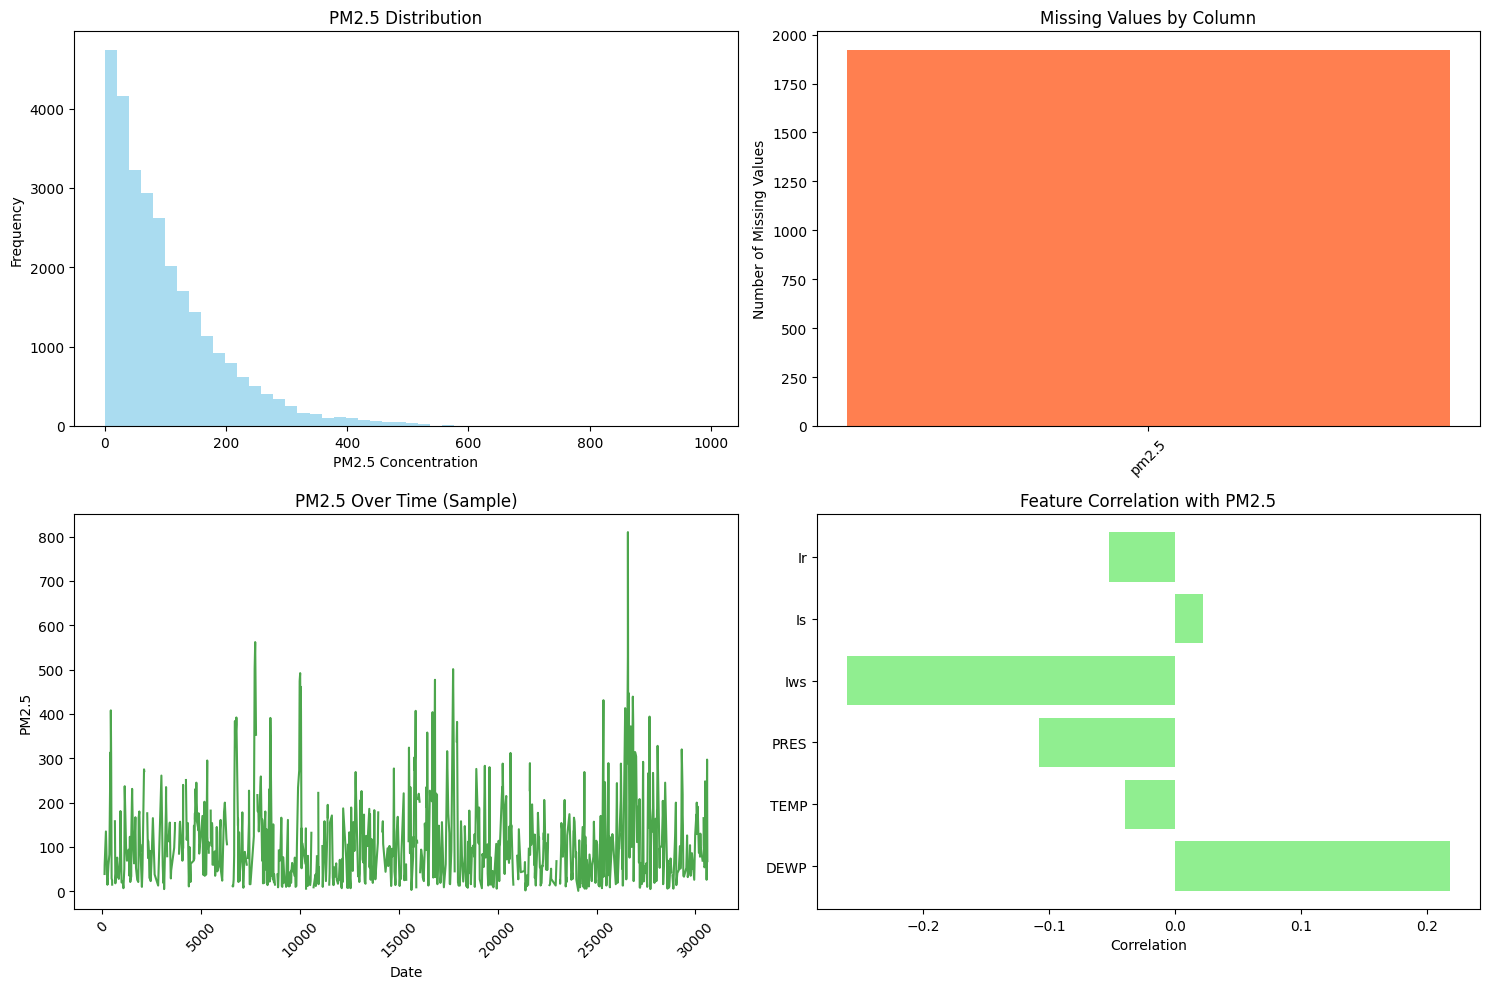

In [5]:
# cell 5: visualizing the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(train['pm2.5'].dropna(), bins=50, color='skyblue', alpha=0.7)
axes[0,0].set_title('PM2.5 Distribution')
axes[0,0].set_xlabel('PM2.5 Concentration')
axes[0,0].set_ylabel('Frequency')

missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) > 0:
    axes[0,1].bar(range(len(missing_counts)), missing_counts.values, color='coral')
    axes[0,1].set_title('Missing Values by Column')
    axes[0,1].set_xticks(range(len(missing_counts)))
    axes[0,1].set_xticklabels(missing_counts.index, rotation=45)
    axes[0,1].set_ylabel('Number of Missing Values')
else:
    axes[0,1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Missing Values by Column')

# PM2.5 over time
sample_data = train.sample(n=min(1000, len(train))).sort_index()
axes[1,0].plot(sample_data.index, sample_data['pm2.5'], alpha=0.7, color='green')
axes[1,0].set_title('PM2.5 Over Time (Sample)')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('PM2.5')
axes[1,0].tick_params(axis='x', rotation=45)

# correlation
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
correlations = train[numeric_cols + ['pm2.5']].corr()['pm2.5'].drop('pm2.5')
axes[1,1].barh(range(len(correlations)), correlations.values, color='lightgreen')
axes[1,1].set_title('Feature Correlation with PM2.5')
axes[1,1].set_yticks(range(len(correlations)))
axes[1,1].set_yticklabels(correlations.index)
axes[1,1].set_xlabel('Correlation')

plt.tight_layout()
plt.show()

In [6]:
# cell 5: Convert datetime and set index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
# cell 6: Using forward filling to fill missing values
train = train.fillna(method='ffill').fillna(train.mean())
test = test.fillna(method='ffill').fillna(test.mean())

# Feature Engin: create time-based features
def create_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)
    return df

train = create_time_features(train)
test = create_time_features(test)

feature_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
                'hour', 'day_of_week', 'month', 'season']
X_train = train[feature_cols]
y_train = train['pm2.5']
X_test = test[feature_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test_scaled.shape}")

Training features shape: (30676, 13)
Training target shape: (30676,)
Test features shape: (13148, 13)


/tmp/ipython-input-1657074414.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(train.mean())
/tmp/ipython-input-1657074414.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='ffill').fillna(test.mean())


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
# cell 7: Create sequences for LSTM
def create_sequences(X, y, sequence_length=24):
    """Creating sequences that use 24 hours to predict next hour"""
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y.iloc[i])

    return np.array(X_seq), np.array(y_seq)

def create_test_sequences(X, sequence_length=24):
    """sequences for test data"""
    X_seq = []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])

    return np.array(X_seq)

sequence_length = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
X_test_seq = create_test_sequences(X_test_scaled, sequence_length)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training targets shape: {y_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

split_idx = int(0.8 * len(X_train_seq))
X_train_final = X_train_seq[:split_idx]
X_val = X_train_seq[split_idx:]
y_train_final = y_train_seq[:split_idx]
y_val = y_train_seq[split_idx:]

print(f"\nAfter train-val split:")
print(f"Train: {X_train_final.shape}, Val: {X_val.shape}")

Training sequences shape: (30652, 24, 13)
Training targets shape: (30652,)
Test sequences shape: (13124, 24, 13)

After train-val split:
Train: (24521, 24, 13), Val: (6131, 24, 13)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [9]:
# cell 8:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_lstm_model(input_shape, config='basic'):
    model = Sequential()

    if config == 'basic':
        model.add(LSTM(64, activation='tanh', input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

    elif config == 'deep':
        model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(LSTM(64, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

    elif config == 'regularized':
        model.add(LSTM(96, activation='tanh', input_shape=input_shape,
                      kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(48, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))

    return model

# Create and compile the model
input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model = create_lstm_model(input_shape, config='regularized')

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
]

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,329 (184.88 KB)

 Trainable params: 47,137 (184.13 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# cell 9:  Train the model with experiment tracking
import time

def train_and_evaluate(model, X_train, y_train, X_val, y_val, callbacks, epochs=100, batch_size=64):
    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    train_time = time.time() - start_time

    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_rmse = history.history['rmse'][-1]
    val_rmse = history.history['val_rmse'][-1]

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'training_time': train_time,
        'epochs_trained': len(history.history['loss']),
        'history': history
    }

# Train the model
print("Training advanced LSTM model...")
results = train_and_evaluate(
    model, X_train_final, y_train_final, X_val, y_val,
    callbacks, epochs=100, batch_size=64
)

print(f"\nTraining Results:")
print(f"Final Training RMSE: {results['train_rmse']:.2f}")
print(f"Final Validation RMSE: {results['val_rmse']:.2f}")
print(f"Training Time: {results['training_time']:.1f}s")
print(f"Epochs Trained: {results['epochs_trained']}")

Training advanced LSTM model...
Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 11676.0996 - rmse: 107.5406 - val_loss: 8017.9014 - val_rmse: 89.5426 - learning_rate: 0.0010
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 5719.3208 - rmse: 75.6082 - val_loss: 8353.8604 - val_rmse: 91.3993 - learning_rate: 0.0010
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 4705.4028 - rmse: 68.5757 - val_loss: 6251.8726 - val_rmse: 79.0685 - learning_rate: 0.0010
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 4346.5103 - rmse: 65.9108 - val_loss: 6721.7026 - val_rmse: 81.9857 - learning_rate: 0.0010
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 3962.1052 - rmse: 62.9391 - val_loss: 6717.8433 - val_rmse: 81.9622 - learning_rate: 0.0010
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 3939.7195 - rmse: 62.7585 - val_loss: 5751.2705 - val_rmse: 75.8368 - learning_rate: 0.0010
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━

### Plots of the model's performance

767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


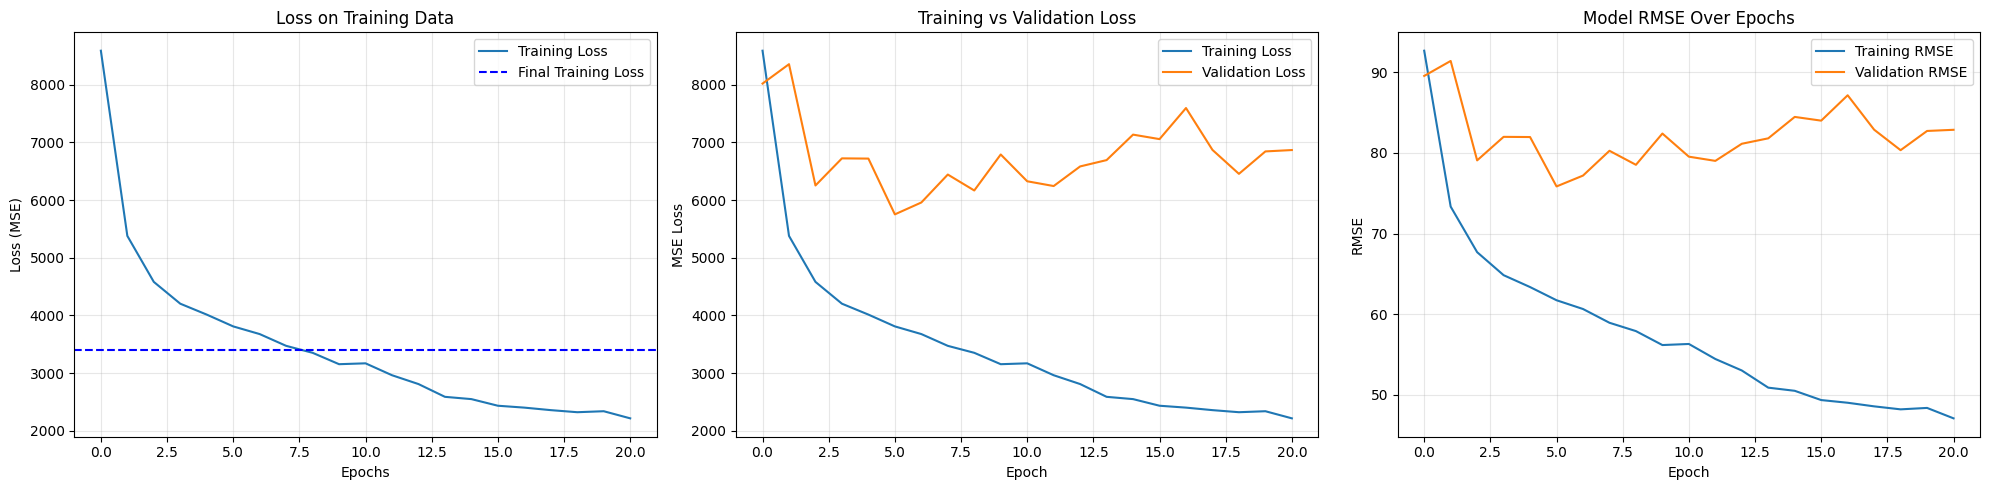

Final Training Loss (MSE): 3398.93
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Final Validation RMSE: 75.84
Target RMSE: 4000
Current RMSE: 75.84
Meeting target: YES


In [11]:
# cell 10: Performance visualization (keeping facilitator's style for training loss)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Training Loss Plot (facilitator's style)
train_predictions = model.predict(X_train_final)
train_loss = np.mean((y_train_final - train_predictions.flatten())**2)

axes[0].plot(results['history'].history['loss'], label='Training Loss')
axes[0].axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss')
axes[0].set_title('Loss on Training Data')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Loss comparison
axes[1].plot(results['history'].history['loss'], label='Training Loss')
axes[1].plot(results['history'].history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RMSE curves
axes[2].plot(results['history'].history['rmse'], label='Training RMSE')
axes[2].plot(results['history'].history['val_rmse'], label='Validation RMSE')
axes[2].set_title('Model RMSE Over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('RMSE')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss (MSE): {train_loss:.2f}")

# Validation predictions analysis
val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val - val_pred.flatten())**2))
print(f"Final Validation RMSE: {val_rmse:.2f}")

target_rmse = 4000
print(f"Target RMSE: {target_rmse}")
print(f"Current RMSE: {val_rmse:.2f}")
print(f"Meeting target: {'YES' if val_rmse < target_rmse else 'NO'}")

In [12]:
# cell 11: Experimenting
def run_quick_experiments():
    """Run multiple quick experiments with different configurations"""
    experiments = []

    configs = [
        {'name': 'Basic LSTM', 'config': 'basic', 'lr': 0.001, 'batch': 64, 'dropout': 0.2},
        {'name': 'Deep LSTM', 'config': 'deep', 'lr': 0.001, 'batch': 32, 'dropout': 0.3},
        {'name': 'Regularized LSTM', 'config': 'regularized', 'lr': 0.0005, 'batch': 64, 'dropout': 0.3}
    ]

    for exp in configs:
        print(f"\nRunning {exp['name']}...")

        # Create model
        temp_model = create_lstm_model(input_shape, exp['config'])
        temp_model.compile(
            optimizer=Adam(learning_rate=exp['lr']),
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
        )


        temp_history = temp_model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=exp['batch'],
            verbose=0
        )

        final_val_rmse = temp_history.history['val_rmse'][-1]

        experiments.append({
            'Experiment': exp['name'],
            'Architecture': exp['config'],
            'Learning_Rate': exp['lr'],
            'Batch_Size': exp['batch'],
            'Dropout': exp['dropout'],
            'Sequence_Length': 24,
            'Epochs': 20,
            'Val_RMSE': round(final_val_rmse, 2)
        })

    return experiments

# run experiments and create table of the experiements
experiment_results = run_quick_experiments()
experiment_df = pd.DataFrame(experiment_results)

print("\nExperiment Results Table:")
print(experiment_df.to_string(index=False))

experiment_df.to_csv('experiment_results.csv', index=False)
print("\nExperiment table saved as 'experiment_results.csv'")


Running Basic LSTM...

Running Deep LSTM...

Running Regularized LSTM...

Experiment Results Table:
      Experiment Architecture  Learning_Rate  Batch_Size  Dropout  Sequence_Length  Epochs  Val_RMSE
      Basic LSTM        basic         0.0010          64      0.2               24      20     88.41
       Deep LSTM         deep         0.0010          32      0.3               24      20     92.59
Regularized LSTM  regularized         0.0005          64      0.3               24      20     85.39

Experiment table saved as 'experiment_results.csv'


### Generate final predictions

In [13]:
# cell 12: Generate final predictions using sample_submission format
print("Generating final predictions")

print(f"Sample submission shape: {sample_submision.shape}")
print("Sample submission format:")
print(sample_submision.head())

sequence_predictions = model.predict(X_test_seq, verbose=0)
sequence_predictions = np.nan_to_num(sequence_predictions)
sequence_predictions = np.round(sequence_predictions).astype(int)

full_predictions = np.zeros(len(sample_submision))

full_predictions[sequence_length:] = sequence_predictions.flatten()

fallback_value = int(np.round(train['pm2.5'].mean()))
full_predictions[:sequence_length] = fallback_value

submission = sample_submision.copy()
submission['pm2.5'] = full_predictions

submission['pm2.5'] = np.nan_to_num(submission['pm2.5'])

print(f"\nSubmission shape: {submission.shape}")
print(f"Required shape: {sample_submision.shape}")
print(f"Shape match: {submission.shape == sample_submision.shape}")

print("\nSample predictions:")
print(submission.head())
print("\nLast few predictions:")
print(submission.tail())

submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/final_submission.csv', index=False)
print("\nSubmission saved as 'final_submission.csv'")

print(f"\nFinal Model Summary:")
print(f"Architecture: Regularized LSTM with BatchNorm")
print(f"Sequence Length: 24 hours")
print(f"Features: {X_train_final.shape[2]} (including engineered time features)")
print(f"Predictions from LSTM: {len(sequence_predictions)}")
print(f"Fallback predictions: {sequence_length}")
print(f"Total predictions: {len(full_predictions)}")
print(f"Final Validation RMSE: {results['val_rmse']:.2f}")
print(f"Target Achievement: {'SUCCESS' if results['val_rmse'] < 4000 else 'NEEDS IMPROVEMENT'}")

Generating final predictions...
Sample submission shape: (13148, 2)
Sample submission format:
               row ID  pm2.5
0  2013-07-02 4:00:00     14
1  2013-07-02 5:00:00     14
2  2013-07-02 6:00:00     14
3  2013-07-02 7:00:00     14
4  2013-07-02 8:00:00     14

Submission shape: (13148, 2)
Required shape: (13148, 2)
Shape match: True

Sample predictions:
               row ID  pm2.5
0  2013-07-02 4:00:00   99.0
1  2013-07-02 5:00:00   99.0
2  2013-07-02 6:00:00   99.0
3  2013-07-02 7:00:00   99.0
4  2013-07-02 8:00:00   99.0

Last few predictions:
                    row ID  pm2.5
13143  2014-12-31 19:00:00   11.0
13144  2014-12-31 20:00:00   11.0
13145  2014-12-31 21:00:00   11.0
13146  2014-12-31 22:00:00   11.0
13147  2014-12-31 23:00:00   11.0

Submission saved as 'final_submission.csv'

Final Model Summary:
Architecture: Regularized LSTM with BatchNorm
Sequence Length: 24 hours
Features: 13 (including engineered time features)
Predictions from LSTM: 13124
Fallback predictio